# Predicting survival on the Titanic


_This notebook contains Python script I used to predict the survival of passengers._

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

The aim of this problem is to classify passengers in two categories (survived or did not survive). The metric used to rank submissions is prediction accuracy.

## Structure

I followed the following steps to classify passengers as accurately as possible:
> ### 1- Cleaning the dataset
> ### 2- Exploratory analysis
> ### 3- Preprocessing the dataset
> ### 4- Model selection and assesment

***

## 1 - Cleaning the dataset
I first had a quick look at the datasets available, their shape and the type of data in each column, as well as to see if there were any columns with missing data.

In [169]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

train_df=pd.read_csv('titanic_data/train.csv', encoding='latin-1')
test_df=pd.read_csv('titanic_data/test.csv', encoding='latin-1')
print(train_df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [170]:
print(train_df.shape, test_df.shape)

(891, 12) (418, 11)


In [171]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [172]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


The split between the train and the test datasets is roughly 70-30. 

Here we are dealing with both categorical features (__Sex__, __Embarked__, __Pclass__), discrete numerical features (__SibSp__, __Parch__), continuous numerical features (__Age__, __Fare__) and "raw" data (__Ticket__, __Cabin__ and __Name__).

### Creating extra features

Some extra features can be created based on the existing set of features:
- __Title__ (Mr, Mrs, Miss, Master and Other) based on passengers' names
- __Block__ (A, B, C, D, E, F, G, T or U for Unknown) based on __Cabin__. Some passengers have several cabins, while others have none.

I defined the functions below to create those extra features:

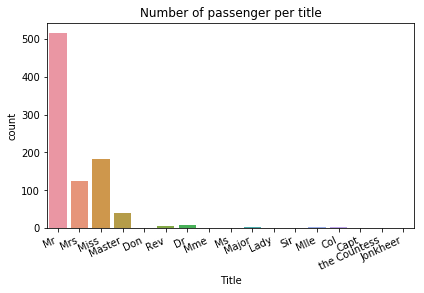

In [173]:
def extract_title(df):
    df['Title']=df.Name.apply(lambda x: x.split(', ')[1].split('.')[0])
    return(df)

def extract_block_letter(df):
    df.Cabin=df.Cabin.fillna('U')
    df.Cabin=df.Cabin.astype(str)
    df['Block']=df.Cabin.apply(lambda c:c[0])
    return(df)

train_df=extract_title(train_df)
train_df=extract_block_letter(train_df)

title_plot=sns.countplot(x='Title', data=train_df)
title_plot.set_xticklabels(title_plot.get_xticklabels(), rotation=25, ha="right")
plt.tight_layout()
plt.title('Number of passenger per title')
plt.show()

Here I decided to use only the 4 most frequent titles ('Mr', 'Mrs', 'Miss' and 'Master'), and grouped the rest under the name 'Other'. 

In [174]:
def simplify_titles(df):
    main_titles=['Mr', 'Mrs', 'Miss', 'Master']
    df['Title'].loc[~df['Title'].isin(main_titles)]='Other'
    return(df)

train_df=simplify_titles(train_df)

### Dealing with missing data

In [175]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
Title            0
Block            0
dtype: int64

In [176]:
test_df.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

It seems there are rows with missing data in the __Age__, __Fare__, __Embarked__ and __Cabin__ columns in both the training and test 
sets. This is confirmed when we check specifically for null values. 

In [177]:
print(train_df.loc[train_df.Block=='U'].Pclass.value_counts()/train_df.loc[train_df.Block=='U'].shape[0])

3    0.697234
2    0.244541
1    0.058224
Name: Pclass, dtype: float64


When looking at the __Class__ of the passengers with missing cabin data, roughly 70% of them was from the third class. We can safely infer that cabins were optional for third class passengers. Approximately 6% of the passengers with a missing __Cabin__ number were in first class. We will have to assume that this is actual missing data i.e. they had a cabin but it is not in the dataset.

Missing data in other columns in the training set (__Age__ and __Embarked__) and in the test set (__Age__ and __Fare__) are replaced using the mean or the most frequent value of the feature, depending on whether the feature is categorical or continuous. For the __Age__ feature, since a large value of rows are affected, I decided to use the __Title__ present in the Name feature as a proxy for the __Age__. To fill missing age values of passengers, I used the average age of passengers with the same __Title__ in the training set. 

In [178]:
def fill_missing_ages(df, train_df):
    titles=['Mr', 'Mrs', 'Miss', 'Master', 'Other']
    avg_age={titles[i]:train_df.loc[train_df['Title']==titles[i]].Age.mean() for i in range(0, len(titles))}
    df.Age=df.apply(lambda row: avg_age[row['Title']] if np.isnan(row['Age']) else row['Age'], axis=1)
    return(df)

train_df=fill_missing_ages(train_df, train_df)

There are only two rows with missing __Embarked__ data. Both of the passengers were single females travelling in first class.

In [179]:
train_df.loc[train_df.Embarked.isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Block
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,B
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,B


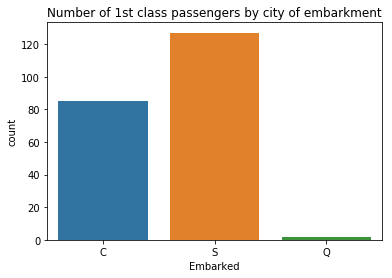

In [180]:
sns.countplot(x='Embarked', data= train_df.loc[train_df.Pclass==1])
plt.title('Number of 1st class passengers by city of embarkment')
plt.show()

Most passengers travelling in first class boarded the Titanic in Southampton. I decided to set those two missing values to 'C'

In [181]:
train_df.Embarked.fillna('S', inplace=True)
test_df.loc[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In the test set, only one passenger has missing __Fare__ data. I set the value of the only missing fare in the test set to the average fare of a 3rd class passenger (from the training set)

In [182]:
test_df.Fare.fillna(train_df.Fare.loc[train_df.Pclass==3].mean(), inplace=True)

***
## 2 - Exploratory analysis

I had a more in-depth look at the different features available to predict passenger survival, first at the impact of categorical variables on the survival rate.

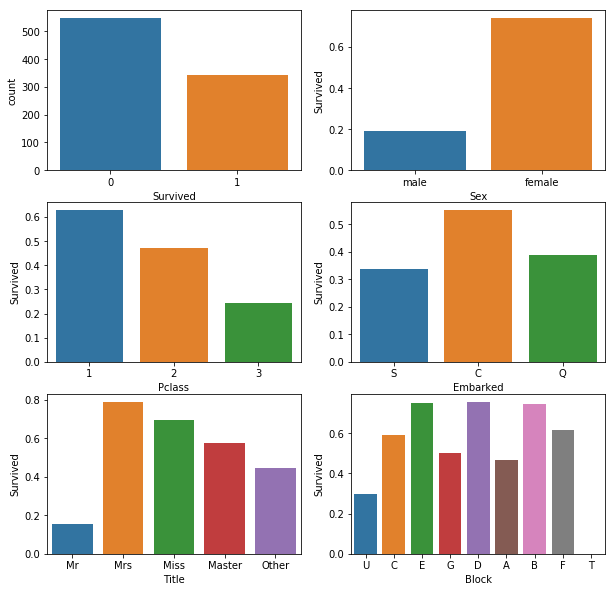

In [183]:
fig, ax = plt.subplots(3,2)
fig.set_size_inches(10, 10)
sns.countplot(x='Survived', data= train_df, ax=ax[0,0])
sns.barplot(x='Sex',y='Survived', data= train_df, ax=ax[0,1], ci=None)
sns.barplot(x='Pclass',y='Survived', data= train_df, ax=ax[1,0], ci=None)
sns.barplot(x='Embarked',y='Survived', data= train_df, ax=ax[1,1], ci=None)
sns.barplot(x='Title',y='Survived', data= train_df, ax=ax[2,0], ci=None)
sns.barplot(x='Block',y='Survived', data= train_df, ax=ax[2,1], ci=None)
plt.show()

We seem to be given a somewhat balanced training set, since 38% of the passengers in the training set survived (compared to 32% overall).

Judging from these plots, we can infer that:
- The class __Pclass__ of the passenger is a good predictor of survival 
- The gender __Sex__ of the passenger is a good predictor of survival 
- The deck letter __Block__ is a good predictor of survival. One hypothesis might be that people closest to the lifeboats had a better chance of survival. 
- The __Title__ of the passenger is a good predictor of survival. What is especially interesting is that young men (whose title is usually 'Master') have a much better chance of survival than older men. Age seems to be an important factor of survival.

Next, I checked the continuous variables, and how they influenced passenger survival.
The __Fare__ feature is especially interesting. It seems that 75% of the passengers in the training set paid £31 or less to board the boat, while the 10 most expensive ticket cost more than £240. 

In [184]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.755090,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.277584,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,21.773973,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,30.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.898148,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


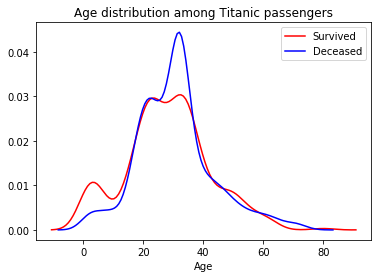

In [185]:
sns.distplot(train_df.loc[train_df.Survived==1].Age,bins=(0,6,13,18,25,35,60,100), hist=False, color='red', label='Survived')
sns.distplot(train_df.loc[train_df.Survived==0].Age,bins=(0,6,13,18,25,35,60,100), hist=False, color='blue', label='Deceased')
plt.title('Age distribution among Titanic passengers')
plt.autoscale()
plt.show()

When plotting the __Age__ distribution of surviors and of deceased passengers, we can see that children under 10 seem to take a larger proportion of the survivor population, while adults over 30 are more frequent in the deceased population.

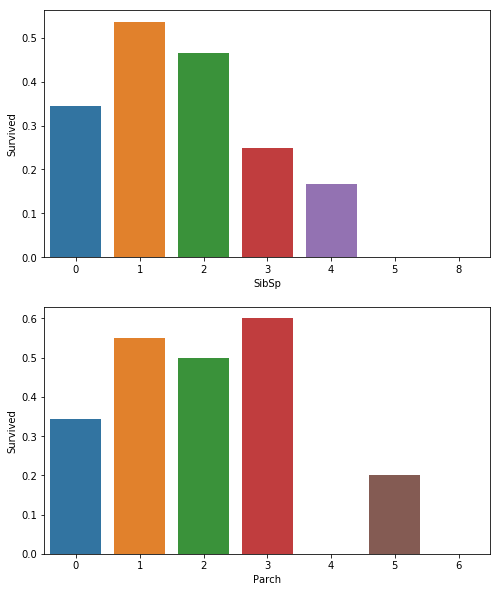

In [186]:
fig, ax =plt.subplots(2)
fig.set_size_inches(8, 10)
sns.barplot(x='SibSp', y='Survived', data=train_df, ax=ax[0], ci=None)
sns.barplot(x='Parch', y='Survived', data=train_df, ax=ax[1], ci=None)
plt.show()

Next, I looked at the relationships between passengers, and how they impacted their survival. It seems that being part of a family initially boosts chances of survival if its size __SibSp__ is small enough (up to one other person), but it hinders them as soon as the family is larger than two members.

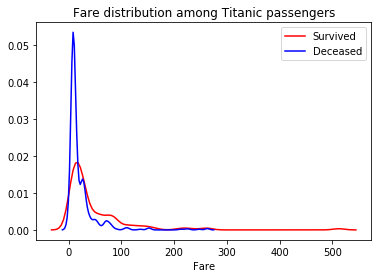

In [187]:
sns.distplot(train_df.loc[(train_df.Survived==1)].Fare, hist=False, color='red', label='Survived')
sns.distplot(train_df.loc[(train_df.Survived==0)].Fare, hist=False, color='blue', label='Deceased')
plt.autoscale()
plt.title('Fare distribution among Titanic passengers')
plt.show()

Then, I looked at the __Fare__ distribution among survivors and deceased passengers. It seems that people that paid a low fare (approximately under £20) make up a much larger proportion of the deceased population than the survivor population.

Based on these first insights, I decided to encode the __Age__ and __Fare__ features into categorical variables using value bins.

I encoded the __Age__ feature into 7 categories: Infant (0 to 6), Child (6 to 13), Teen (13 to 18), Student (18 to 25), Young Adult (25 to 40), Adult (40 to 60) and Elderly (60+). I encoded the __Fare__ feature using 4 categories based on its quartiles. I used the two functions below to encode the variables.

In [188]:
def create_age_buckets(df):
    bins = (-1, 6, 13, 18, 25, 40, 60, 100)
    group_names = ['Infant', 'Child', 'Teen', 'Student', 'Young_Adult', 'Adult', 'Elderly']
    buckets = pd.cut(df.Age, bins, labels=group_names)
    df.Age = buckets
    return(df)

def create_fare_buckets(df):
    bins=(-1,8,15,31,1000)
    group_names = ['1_quartile', '2_quartile', '3_quartile', '4_quartile']
    categories = pd.cut(df.Fare, bins, labels=group_names)
    df.Fare = categories
    return(df)

train_df=create_age_buckets(train_df)
train_df=create_fare_buckets(train_df)

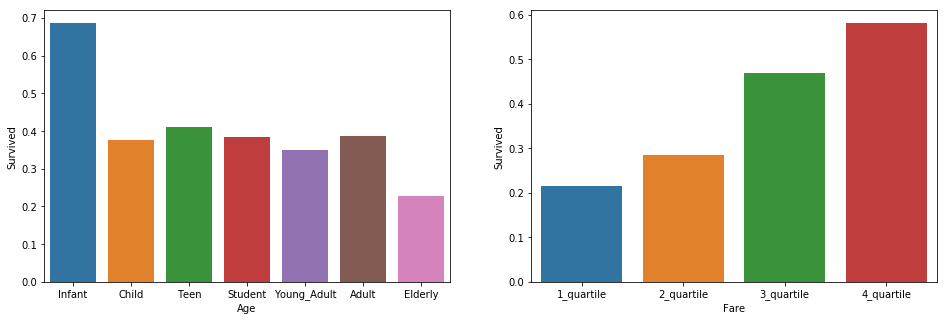

In [189]:
fig, ax =plt.subplots(1,2)
fig.set_size_inches(16, 5)
sns.barplot(x='Age', y='Survived', data=train_df, ax=ax[0], ci=None)
sns.barplot(x='Fare', y='Survived', data=train_df, ax=ax[1], ci=None)
plt.show()

The two graphs above confirm the fact that younger passengers as well as passengers with higher fares had a better survival rate than others.
***
## 3 - Preprocessing the dataset

I created a _preprocess_ function, that can also be used on the test set. It aggregates all the transformations I did so far on the training set.
The *encode_variables* function transforms the continuous features __Fare__ and __Age__ into categorical features, and encodes categorical feeatures as binary features.

In [194]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

train_df=pd.read_csv('titanic_data/train.csv', encoding='latin-1')
test_df=pd.read_csv('titanic_data/test.csv', encoding='latin-1')

def preprocess(df, train_df):
    # extracting extra features and dealing with missing data
    df=extract_title(df)
    df=extract_block_letter(df)
    df=simplify_titles(df)
    df=fill_missing_ages(df, train_df)
    df.Embarked.fillna('S', inplace=True)
    df.Fare.fillna(train_df.Fare.loc[train_df.Pclass==3].mean(), inplace=True)
    return(df)
    
train_df=preprocess(train_df, train_df)
test_df=preprocess(test_df, train_df)

def encode_variables(train_df, test_df):
    train_df=create_age_buckets(train_df)
    train_df=create_fare_buckets(train_df)
    test_df=create_age_buckets(test_df)
    test_df=create_fare_buckets(test_df)
    split_index=train_df.shape[0]
    total_df=pd.concat([train_df.drop(['Survived'], axis=1),test_df], axis=0, ignore_index=True)
    total_df=pd.concat([total_df.drop(['Pclass','Sex','Block', 'Age', 'Fare','Embarked','Title'], axis=1),pd.get_dummies(total_df['Pclass'].astype(str), drop_first=False, prefix='Pclass'), pd.get_dummies(total_df[['Sex','Age','Fare', 'Embarked', 'Title', 'Block']], drop_first=False)],axis=1)
    
    #dropping unused columns
    total_df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
    return(total_df.iloc[:split_index], train_df.Survived, total_df.iloc[split_index:])

X, y, test_df=encode_variables(train_df, test_df)
print(X.columns)

Index(['SibSp', 'Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female',
       'Sex_male', 'Age_Infant', 'Age_Child', 'Age_Teen', 'Age_Student',
       'Age_Young_Adult', 'Age_Adult', 'Age_Elderly', 'Fare_1_quartile',
       'Fare_2_quartile', 'Fare_3_quartile', 'Fare_4_quartile', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Other', 'Block_A', 'Block_B', 'Block_C', 'Block_D',
       'Block_E', 'Block_F', 'Block_G', 'Block_T', 'Block_U'],
      dtype='object')


In [217]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)
scaler=StandardScaler()
clf=LogisticRegression(penalty='l2', solver='liblinear', fit_intercept=False)
clf.fit(scaler.fit_transform(X_train), y_train)
print('Cross validation score is %0.2f +/- %0.2f'%(cross_val_score(clf,scaler.transform(X),y, cv=5).mean(), cross_val_score(clf,scaler.transform(X),y, cv=5).std()))

Cross validation score is 0.79 +/- 0.02


The proportion of deceased passengers in the training set is roughly 62%. This means that my baseline Logistic regression model performs better than an algorithm that would always give __Survived__ $ = $ 0 as output, because it would only reach approximately 62% accuracy. 

Next, I compared coefficients of the Logistic regression model of each feature since I normalized the dataset. I tried to see if some assumptions I drew in while conductying exploratory analysis were confirmed.

In [218]:
coef_df=pd.DataFrame()
coef_df['Features']=list(X_train.columns)
coef_df['Coef']=clf.coef_[0]
print(coef_df.sort_values(['Coef']))

           Features      Coef
6          Sex_male -0.907407
0             SibSp -0.821813
1             Parch -0.428428
22       Title_Miss -0.371686
15  Fare_2_quartile -0.270994
34          Block_U -0.263816
12        Age_Adult -0.256031
4          Pclass_3 -0.246931
13      Age_Elderly -0.136983
14  Fare_1_quartile -0.130912
20       Embarked_S -0.104824
33          Block_T -0.092507
26          Block_A -0.088075
32          Block_G -0.074209
28          Block_C -0.021024
24        Title_Mrs -0.009522
8         Age_Child -0.004411
11  Age_Young_Adult  0.008560
23         Title_Mr  0.025281
31          Block_F  0.030827
25      Title_Other  0.033742
9          Age_Teen  0.046709
10      Age_Student  0.047626
18       Embarked_C  0.057228
16  Fare_3_quartile  0.086998
19       Embarked_Q  0.087385
3          Pclass_2  0.137641
2          Pclass_1  0.155510
27          Block_B  0.176920
29          Block_D  0.253501
30          Block_E  0.272544
17  Fare_4_quartile  0.317110
7        A

The hunch I had on female passengers shaving a higher chance of survival is confirmed. Furthermore, young men (passengers with the __Title__ 'Master') do have a higher chance of survival than older men. Down at the other end of the scale, being a male passenger (with the __Title__ 'Mister'), being part of a large family or travelling in 3rd class have indeed a negative impact on survival.

Next, I decided to compare several model by doing a grid-search cross validation. This method finds the best hyperparameters of each model, and returns its best performance (given by the optimal set of hyperparameters).
I picked 
- a Logistic regression with recursive feature elimination to find the best subset of features to use, since there seems to be some rather weak predictors in our model
- a Ridge classifier to use regularization to reduce feature multicollinearity, knowing that its L2 penalty enables us to do a smoother shrinkage
- a linear Support Vector Classifier
- a K Nearest Neighbors Classifier

I split the training set in two, one part used to find the best hyperparameters of each model, the other to assess each model one unseen data and compare their performance.

In [219]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFECV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

#Recursive feature elimination
clf=LogisticRegression(fit_intercept=False)
best_subset=RFECV(clf)
best_subset.fit(scaler.transform(X_train), y_train)
print('Logistic regression with RFE test accuracy is %0.2f'%best_subset.score(scaler.transform(X_test), y_test))
print('Subset selection returns %i features'%best_subset.n_features_)

#K Nearest Neighbor classifier
param_grid={'n_neighbors':[3,5,7], 'weights':['uniform', 'distance']}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(scaler.transform(X_train), y_train)
print('KNN test accuracy is %0.2f'%grid_search.score(scaler.transform(X_test), y_test))
print(grid_search.best_params_)

#Ridge classifier
param_grid={'alpha':np.arange(1,5,0.25),'fit_intercept':[False]}
grid_search = GridSearchCV(RidgeClassifier(), param_grid, cv=5)
grid_search.fit(scaler.transform(X_train), y_train)
print('Ridge test accuracy is %0.2f'%grid_search.score(scaler.transform(X_test), y_test))
print(grid_search.best_params_)

#Support vector classifier
param_grid={'C':np.arange(1,10,1), 'fit_intercept':[False]}
grid_search = GridSearchCV(LinearSVC(), param_grid, cv=5)
grid_search.fit(scaler.transform(X_train), y_train)
print('Linear SVC test accuracy is %0.2f'%grid_search.score(scaler.transform(X_test), y_test))
print(grid_search.best_params_)

Logistic regression with RFE test accuracy is 0.78
Subset selection returns 29 features
KNN test accuracy is 0.74
{'n_neighbors': 5, 'weights': 'distance'}
Ridge test accuracy is 0.80
{'alpha': 1.0, 'fit_intercept': False}
Linear SVC test accuracy is 0.80
{'C': 6, 'fit_intercept': False}


A few observations:

Here, the Ridge classifier and linear SVC models outperform the baseline model. They are generally thought to be the most adapted models to this type of problem, since we do have colinearity between variables, to some degree (passengers in 3rd class are more likely to be in the 1st fare quartile for example). 

Combining Logistic regression with subset selection yields a poorer performance than Ridge classification. This is not surprising because because subset selection is a discrete process that often exhibit high variance so doesn't reduce prediction error, whereas shrinkage methods such as Ridge (or Lasso) are continuous, ensuring a "soft-thresholding" procedure.

In [206]:
grid_search.best_estimator_.fit(scaler.fit_transform(X),y)
y_pred=grid_search.best_estimator_.predict(test_df)

I get a score of 0.761 after submitting predictions obtained using the Ridge classifier model. 
There is a notable difference between the cross-validation accuracy and the score I get after submitting my result file. This might be because the train set has a different distribution than the test set used for the prediction.